In [1]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["figure.constrained_layout.use"] = True
import seaborn as sns

sns.set(style="whitegrid")
import pandas as pd

In [64]:
counts = pd.read_csv(
    "/Users/vajk/Library/CloudStorage/OneDrive-Személyes/GitHub/PythonDataScienceHandbook/notebooks/data/Fremont_Bridge.csv",
    sep=",",
    index_col="Date",
    parse_dates=True,
)
weather = pd.read_csv(
    "/Users/vajk/Library/CloudStorage/OneDrive-Személyes/GitHub/PythonDataScienceHandbook/notebooks/data/BicycleWeather.csv",
    sep=",",
    index_col="DATE",
    parse_dates=True,
)

In [65]:
max_index = weather.index.max()
max_index

Timestamp('2015-09-01 00:00:00')

In [66]:
max_index_c = counts.index.tolist().index(max_index)
# df = df.filter(items=range(4), axis=0)
counts = counts.loc[counts.index <= max_index]
counts.index.max()

Timestamp('2015-09-01 00:00:00')

In [67]:
daily = counts.resample("d").sum()
daily["Total"] = daily.sum(axis=1)
daily = daily[["Total"]]

days = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
for i in range(7):
    daily[days[i]] = (daily.index.dayofweek == i).astype(float)

In [68]:
from pandas.tseries.holiday import USFederalHolidayCalendar

cal = USFederalHolidayCalendar()
holidays = cal.holidays("2012", "2016")
daily = daily.join(pd.Series(1, index=holidays, name="holiday"))
daily.holiday.fillna(0, inplace=True)
daily.head()

,Total,Mon,Tue,Wed,Thu,Fri,Sat,Sun,holiday
Date,,,,,,,,,
2012-10-03,7042.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2012-10-04,6950.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2012-10-05,6296.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2012-10-06,4012.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2012-10-07,4284.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


(8.0, 17.0)

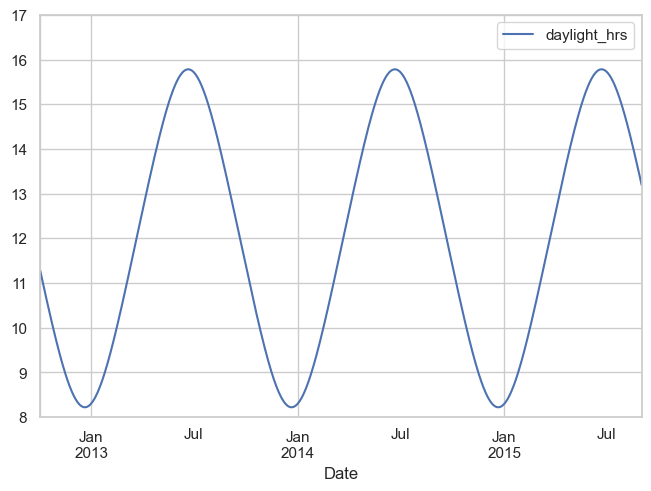

In [70]:
from datetime import datetime


def hours_of_daylight(date, axis=23.44, latitude=47.61):
    """Compute the hours of daylight for the given date"""
    days = (date - datetime(2000, 12, 21)).days
    m = 1.0 - np.tan(np.radians(latitude)) * np.tan(
        np.radians(axis) * np.cos(days * 2 * np.pi / 365.25)
    )
    return 24.0 * np.degrees(np.arccos(1 - np.clip(m, 0, 2))) / 180.0


daily["daylight_hrs"] = list(map(hours_of_daylight, daily.index))
daily[["daylight_hrs"]].plot()
plt.ylim(8, 17)

In [74]:
max_hours = daily["daylight_hrs"].max()
max_hours

15.781094837252823

Text(2014-06-22T00:00:00.000000000, 15.781094837252823, '15.78')

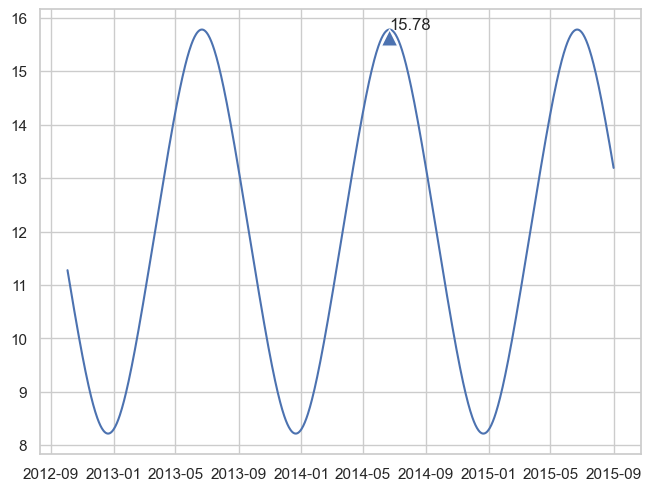

In [104]:
fig, ax = plt.subplots()
(li,) = ax.plot(daily.index, daily.daylight_hrs)
local_max = li.get_data()[1]
(i,) = np.where(local_max == max_hours)
i = i[0]
x = li.get_data()[0][i]
y = li.get_data()[1][i]
ax.annotate(round(max_hours, 2), xy=(x, y), arrowprops={"width": 20})

In [105]:
# temperatures are in 1/10 deg C; convert to C
weather["TMIN"] /= 10
weather["TMAX"] /= 10
weather["Temp (C)"] = 0.5 * (weather["TMIN"] + weather["TMAX"])

# precip is in 1/10 mm; convert to inches
weather["PRCP"] /= 254
weather["dry day"] = (weather["PRCP"] == 0).astype(int)

daily = daily.join(weather[["PRCP", "Temp (C)", "dry day"]])
daily["annual"] = (daily.index - daily.index[0]).days / 365.0

In [106]:
daily.dropna(axis=0, how="any", inplace=True)

column_names = [
    "Mon",
    "Tue",
    "Wed",
    "Thu",
    "Fri",
    "Sat",
    "Sun",
    "holiday",
    "daylight_hrs",
    "PRCP",
    "dry day",
    "Temp (C)",
    "annual",
]
X = daily[column_names]
y = daily["Total"]

In [111]:
from sklearn.linear_model import LinearRegression

model = LinearRegression(fit_intercept=False).fit(X, y)
daily["predicted"] = model.predict(X)

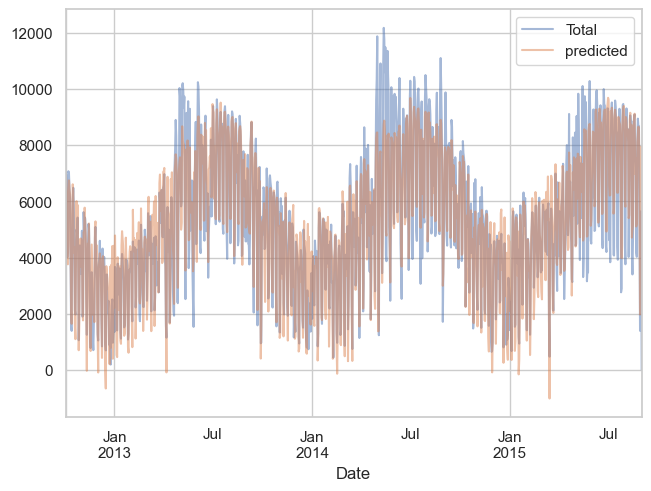

In [113]:
daily[["Total", "predicted"]].plot(alpha=0.5)